# Introduction to ODE modeling

For more examples see the [online Tellurium documentation](http://tellurium.readthedocs.io/en/latest).

## Modeling in a nutshell
**Basic steps**: 
- write down the players (**species Si**) in your system
- write down the **processes vi** which influence your species and the **stoichiometry** (number of species consumed/produced via the process)
- write down mathematical equations for the **processes**
- equations define the **rates** of the processes, defining how fast the process changes the species

** Process **
$$v1: S1 \rightarrow S2$$

$$v1 = k1 \cdot S1$$

**System of ordinary differential equations (ODEs)**

The result is a list of mathematical equations (differential equations)
* can be solved with numerical methods
* results in time courses, i.e., the time-dependent 

$$\frac{dS1}{dt} = -v1 = -k1 \cdot S1$$  
$$\frac{dS2}{dt} = v1 = k1 \cdot S1$$

**Different basic patterns for these kinetic equations exist**
* Mass-Action kinetics
* Michaelis-Menten Kinetics (irreversible & reversible)
* Hill equations (cooperativity)
* Competitive Inhibition

### Mass-Action kinetics (irreversible)
Multiplication of the species in the process (weighted by stoichiometric coefficient) 
in combination with a single parameter

$$v1: c_1 \cdot S1 + c_2 \cdot S2 \rightarrow c_3 \cdot S3 + c_4 \cdot S4$$

$$v1 = k1 \cdot S1^{c_1} \cdot S2^{c_2}$$

concrete example

$$v1: S1 + 2 \cdot S2 \rightarrow S3$$

$$v1 = k1 \cdot S1 \cdot S2^2$$


### Mass-Action kinetics (reversible)
In the reversible Mass-Action kinetics also the backwards reaction (reversible) contributes. 
I.e. the process can als run in the opposite direction

$$v2: c_1 \cdot S1 + c_2 \cdot S2 \leftrightarrow c_3 \cdot S3 + c_4 \cdot S4$$

$$v2 = k1 \cdot S1^{c_1} \cdot S2^{c_2} - k2 \cdot S3^{c_3} \cdot S4^{c_4}$$


In [1]:
import tellurium as te

In [2]:
ma_rev1 = te.loada("""
model ma_rev1()
  v1: S1 -> S2; k1*S1;
  k1 = 0.1
  S1 = 10.0; S2=0.0;
end
""")
ma_rev1.simulate(start=0, end=50, steps=200)
ma_rev1.plot()

**Steady state**  
Steady state of a system is which state is reached after long time.

In [3]:
import pandas as pd
ma_rev1.conservedMoietyAnalysis = True
ss = ma_rev1.steadyState()
df_ss = pd.Series(ma_rev1.getSteadyStateValues(), index=ma_rev1.steadyStateSelections)
display(df_ss)

[S1]     0.0
[S2]    10.0
dtype: float64

**Stoichiometric matrix**  
Matrix of how the species are connected via the processes. This is an important system property for analysis. In this simple example S1 is converted to S2 via the process v1.

In [4]:
ma_rev1.getFullStoichiometryMatrix()

      v1
S1 [[ -1],
S2  [  1]]

**Irreversible Mass Action Example**  

In [5]:
ma_rev2 = te.loada("""
model ma_rev2()
  v1: S1 + 2 S2-> S3; k1*S1*S2^2;
  k1 = 0.01; k2=0.005;
  S1 = 10.0; S2=20.0; S3=0;
end
""")
ma_rev2.simulate(start=0, end=20, steps=200)
ma_rev2.plot()

# steady state analysis
ma_rev2.conservedMoietyAnalysis = True
ss = ma_rev2.steadyState()
df_ss = pd.Series(ma_rev2.getSteadyStateValues(), index=ma_rev2.steadyStateSelections)
display(df_ss)

# stoichiometric matrix
ma_rev2.getFullStoichiometryMatrix()

[S2]    0.000350
[S1]    0.000175
[S3]    9.999825
dtype: float64

      v1
S2 [[ -2],
S1  [ -1],
S3  [  1]]

In [6]:
import pandas as pd
ma_rev1.conservedMoietyAnalysis = True
ss = ma_rev1.steadyState()
df = pd.Series(ma_rev1.getSteadyStateValues(), index=ma_rev1.steadyStateSelections)
df

[S1]     0.0
[S2]    10.0
dtype: float64

### Michaelis-Menten kinetics (irreversible)
Defined via a maximal velocity of the process `Vmax` and an additional parameter `Km` 
which defines the saturation of the enzyme. I.e., at increasing concentration of the substrate at some concentration the enzyme is saturated

$$v1: c_1 \cdot S1 \rightarrow c_2 \cdot S2$$

$$v1: S1 \rightarrow S2$$

$$v1 = Vmax \cdot \frac{S1}{Km + S1}$$

In [7]:
# single reaction, irreversible Michaelis-Menten Kinetics
mmk_irev = te.loada("""
model mmk_irev()
  v1: S1 -> S2; Vmax*S1/(Km+S1)
  Vmax = 1.0
  Km = 1.0
  S1 = 10.0; S2 = 0.0
end
""")
mmk_irev.timeCourseSelections = mmk_irev.timeCourseSelections + mmk_irev.getReactionIds()
print(mmk_irev.timeCourseSelections)
s = mmk_irev.simulate(start=0, end=50, steps=200)
mmk_irev.plot()
print(s)

['time', '[S1]', '[S2]', 'v1']


     time,         [S1],     [S2],           v1
 [[     0,           10,        0,     0.909091],
  [  0.25,      9.77297, 0.227035,     0.907175],
  [   0.5,      9.54642, 0.453581,     0.905181],
  [  0.75,      9.32038, 0.679618,     0.903104],
  [     1,      9.09487, 0.905126,      0.90094],
  [  1.25,      8.86992,  1.13008,     0.898682],
  [   1.5,      8.64554,  1.35446,     0.896325],
  [  1.75,      8.42177,  1.57823,     0.893863],
  [     2,      8.19862,  1.80138,     0.891288],
  [  2.25,      7.97613,  2.02387,     0.888593],
  [   2.5,      7.75434,  2.24566,     0.885771],
  [  2.75,      7.53326,  2.46674,     0.882811],
  [     3,      7.31294,  2.68706,     0.879706],
  [  3.25,      7.09342,  2.90658,     0.876443],
  [   3.5,      6.87474,  3.12526,     0.873012],
  [  3.75,      6.65694,  3.34306,     0.869399],
  [     4,      6.44006,  3.55994,     0.865592],
  [  4.25,      6.22416,  3.77584,     0.861576],
  [   4.5,      6.00929,  3.99071,     0.857332],
  

Text(0,0.5,'v (rate)')

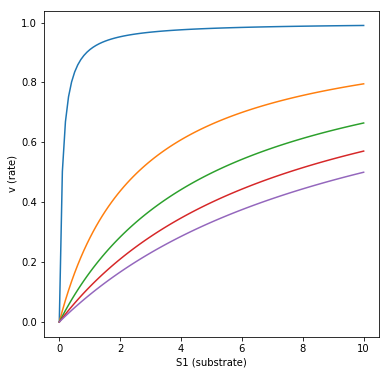

In [8]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
S1 = np.linspace(0, 10, 100)
Km_values = np.linspace(0.1, 10, 5)

def michaelis_menten(s, Vmax=1.0, Km=1.0):
    v = Vmax*S1/(Km+S1)
    return v

# plotting the results
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

for Km in Km_values:
    v = michaelis_menten(S1, Km=Km)
    ax.plot(S1, v)

ax.set_xlabel("S1 (substrate)")
ax.set_ylabel("v (rate)")


### Hill equations (cooperativity)
Defined via a maximal velocity of the process `Vmax`, an additional parameter `Km` and an cooperativity parameter,
$$v1: c_1 \cdot S1 \rightarrow c_2 \cdot S2$$

$$v1: S1 \rightarrow S2$$

$$v1 = Vmax \cdot \frac{S1^n}{Km^n + S1^n}$$

Text(0,0.5,'v (rate)')

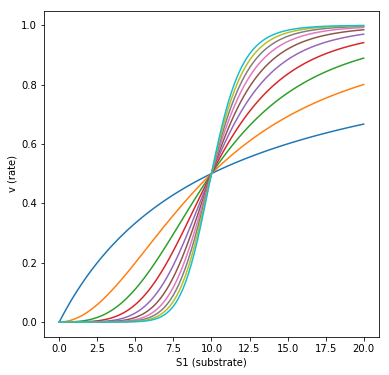

In [9]:
import numpy as np
from matplotlib import pyplot as plt
S1 = np.linspace(0, 20, 100)
n_values = np.linspace(1, 10, 10)

def hill(s, Vmax=1.0, n=1):
    v = Vmax*S1**n/(Km**n+S1**n)
    return v

# plotting the results
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

for n_value in n_values:
    v = hill(S1, n=n_value)
    ax.plot(S1, v)

ax.set_xlabel("S1 (substrate)")
ax.set_ylabel("v (rate)")

## Simple Example (Typical modeling workflows)

This example shows how to set up a simple model in Tellurium and solve it as an ODE. Tellurium uses a human-readable representation of SBML models called [Antimony](http://antimony.sourceforge.net/). The following notebook cell is actually Antimony code - the Tellurium notebook viewer allows you to configure notebook cells as either Antimony, Python, or COMBINE archives. To create Antimony cells, simply select "Convert to Model Cell" from the dropdown in the upper right of a code cell.

When you run the cell below, it will create an instance of the [RoadRunner](http://sys-bio.github.io/roadrunner/python_docs/index.html) simulator. You can use this instance to simulate the model by running the `simulate` function with the start time, end time, and number of points.

In [10]:
import tellurium as te

In [11]:
# single reaction, irreversible mass action kinetics
simple = te.loada("""
model simple()
  S1 -> S2; k1*S1
  k1 = 0.1
  S1 = 10
end
""")

In [12]:
simple.simulate(start=0, end=50, steps=100)
simple.plot()

In [13]:
# what method and simulator
print(simple)

<roadrunner.RoadRunner() { 
'this' : 0x3e83690
'modelLoaded' : true
'modelName' : simple
'libSBMLVersion' : LibSBML Version: 5.14.0
'jacobianStepSize' : 1e-05
'conservedMoietyAnalysis' : false
'simulateOptions' : 
< roadrunner.SimulateOptions() 
{ 
'this' : 0x3eb3f70, 
'reset' : 0,
'structuredResult' : 0,
'copyResult' : 1,
'steps' : 50,
'start' : 0,
'duration' : 50
}>, 
'integrator' : 
< roadrunner.Integrator() >
  name: cvode
  settings:
      relative_tolerance: 0.000001
      absolute_tolerance: 0.000000000001
                   stiff: true
       maximum_bdf_order: 5
     maximum_adams_order: 12
       maximum_num_steps: 20000
       maximum_time_step: 0
       minimum_time_step: 0
       initial_time_step: 0
          multiple_steps: false
      variable_step_size: false

}>


In [14]:
# what method and simulator
sbml_str = simple.getSBML()
antimony_str = te.sbmlToAntimony(sbml_str)
print(sbml_str)
print("-" * 80)
print(antimony_str)

<?xml version="1.0" encoding="UTF-8"?>
<!-- Created by libAntimony version v2.9.4 with libSBML version 5.15.0. -->
<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1">
  <model id="simple" name="simple">
    <listOfCompartments>
      <compartment sboTerm="SBO:0000410" id="default_compartment" spatialDimensions="3" size="1" constant="true"/>
    </listOfCompartments>
    <listOfSpecies>
      <species id="S1" compartment="default_compartment" initialConcentration="10" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
      <species id="S2" compartment="default_compartment" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>
    </listOfSpecies>
    <listOfParameters>
      <parameter id="k1" value="0.1" constant="true"/>
    </listOfParameters>
    <listOfReactions>
      <reaction id="_J0" reversible="true" fast="false">
        <listOfReactants>
          <speciesReference species="S1" stoichiometry="1" con

### Change Parameters
Typical task in modeling is changing parameters and analysing the effect of these paramter changes.

In [15]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams.update({
        'axes.labelsize': 'large', 
        'axes.labelweight': 'bold',
        'axes.titlesize': 'large',
        'axes.titleweight': 'bold',
        'legend.fontsize': 'small',
        'xtick.labelsize': 'large',
        'ytick.labelsize': 'large',
    })

k1 [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


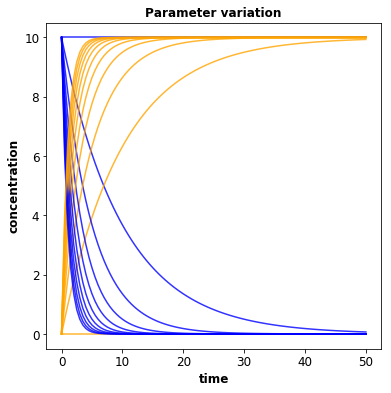

In [16]:
# parameters to vary
k1_values = np.linspace(start=0, stop=1.0, num=11)
print("k1", k1_values)

# perform simulation
results = []
for k1 in k1_values:
    # reset 
    simple.resetAll()
    simple.k1 = k1
    # simulate
    s = simple.simulate(start=0, end=50, steps=100)
    # store results
    results.append(s)
    
# plotting the results
f, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

for s in results:
    time = s["time"]
    ax1.plot(time, s['[S1]'], color="blue", alpha=0.8)
    ax1.plot(time, s['[S2]'], color="orange", alpha=0.8)
    
ax1.set_title("Parameter variation")
ax1.set_xlabel("time")
ax1.set_ylabel("concentration")
plt.show()

### Change Initial Conditions
Another recurring pattern is the change in initial conditions.

S1 [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]


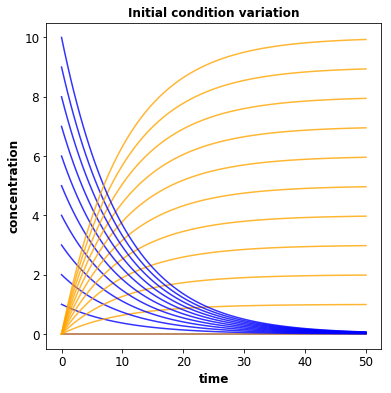

In [17]:
# Initial conditions to vary
S1_values = np.linspace(start=0, stop=10.0, num=11)
print("S1", S1_values)

# perform simulation
results = []
for S1 in S1_values:
    # reset 
    simple.resetAll()
    simple.S1 = S1
    # simulate
    s = simple.simulate(start=0, end=50, steps=100)
    # store results
    results.append(s)
    
# plotting the results
f, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

for s in results:
    time = s["time"]
    ax1.plot(time, s['[S1]'], color="blue", alpha=0.8)
    ax1.plot(time, s['[S2]'], color="orange", alpha=0.8)
    
ax1.set_title("Initial condition variation")
ax1.set_xlabel("time")
ax1.set_ylabel("concentration")
plt.show()

## More Complex Example

Tellurium can also handle stochastic models. This example shows how to select Tellurium’s stochastic solver. The underlying simulation engine used by Tellurium implements a Gibson direct method for simulating this model.

In this example, we run multiple simulations of a stochastic model. Then, we average the simulation trajectories and plot the average trajectory along with the ensemble.

In [18]:
stochastic = te.loada("""
model stochastic()
    J1: S1 -> S2;  k1*S1;
    J2: S2 -> S3; k2*S2 - k3*S3
    J3: S3 -> S4; k4*S3;

    k1 = 0.1; k2 = 0.5; k3 = 0.5; k4 = 0.5;
    S1 = 100;
end
""")

In [19]:
# print(stochastic)

In [20]:
import tellurium as te, numpy as np

# use a stochastic solver
stochastic.integrator = 'gillespie'
stochastic.integrator.seed = 1234
# selections specifies the output variables in a simulation
selections = ['time'] + stochastic.getBoundarySpeciesIds() \
                      + stochastic.getFloatingSpeciesIds()
stochastic.integrator.variable_step_size = False

# run repeated simulation
Ncol = len(stochastic.selections)
Nsim = 30
points = 101
s_sum = np.zeros(shape=[points, Ncol])
for k in range(Nsim):
    stochastic.resetToOrigin()
    s = stochastic.simulate(0, 50, points, selections=selections)
    s_sum += s
    # use show=False to add traces to the current plot
    # instead of starting a new one, equivalent to MATLAB hold on
    stochastic.plot(s, alpha=0.5, show=False)

# add mean curve, legend, show everything and set labels, titles, ...
fig = te.plot(s[:,0], s_sum[:,1:]/Nsim, 
              names=[x + ' (mean)' for x in selections[1:]], 
              title="Stochastic simulation", 
              xtitle="time", ytitle="concentration")